In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import jax.numpy as jnp
from jax import jit, grad, vmap

%matplotlib inline

In [24]:
def gd(func, init, n_epochs=100, lr=1e-4, conj=True, maximize=False):
    params = np.array(init)
    params_traj = np.zeros([n_epochs+1,1], dtype=np.cfloat)
    params_traj[0] = init
    val_func = np.zeros([n_epochs + 1], dtype=np.cfloat)
    val_func[0] = func(*params)
    v = 0

    for j in range(n_epochs):
        v = lr*grad(func)(params[0])
        if conj:
            v = np.conj(v)
        if maximize:
            params = params + v
        else:
            params = params - v
        params_traj[j+1,] = params
        val_func[j+1] = func(*params)
    
    return params_traj, val_func

In [3]:
@jit
def f(z):
    square_mod = z * jnp.conj(z)
    return square_mod.real

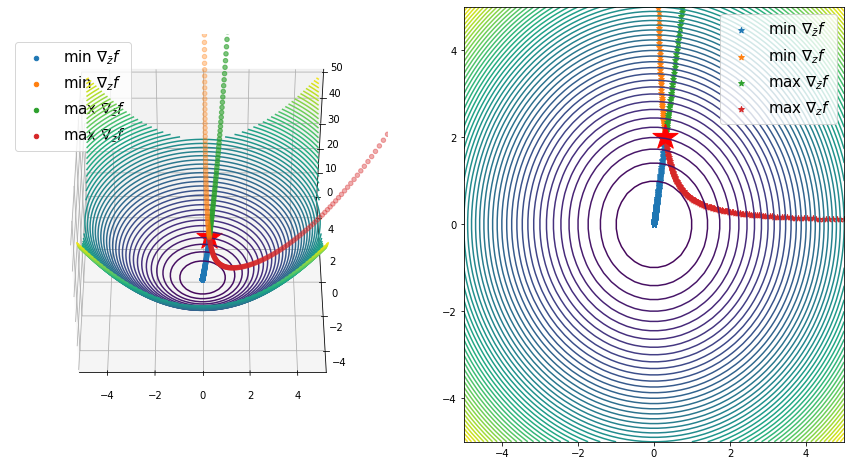

In [14]:
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)

x = np.linspace(-5, 5)
y = np.linspace(-5, 5)
z_values = x + 1.j*y

xx, yy = np.meshgrid(x, y)
z = f(xx + 1.j*yy)

ax1.contour3D(x, y, z, 50)
ax2.contour(x, y, z, 50)

params_traj_conj, val_func_conj = gd(func=f, init=[0.3+2.j], n_epochs=500, lr=1e-2, conj=True, maximize=False)
params_traj, val_func = gd(func=f, init=[0.3+2.j], n_epochs=500, lr=1e-2, conj=False, maximize=False)

params_traj_conj_max, val_func_conj_max = gd(func=f, init=[0.3+2.j], n_epochs=500, lr=1e-2, conj=True, maximize=True)
params_traj_max, val_func_max = gd(func=f, init=[0.3+2.j], n_epochs=500, lr=1e-2, conj=False, maximize=True)

ax1.scatter(params_traj_conj.real, params_traj_conj.imag, val_func_conj, label=r'min $\nabla_{\bar{z}}f$')
ax1.scatter(params_traj.real, params_traj.imag, val_func, label=r'min $\nabla_{z}f$')
ax1.scatter(params_traj_conj_max.real, params_traj_conj_max.imag, val_func_conj_max, label=r'max $\nabla_{\bar{z}}f$')
ax1.scatter(params_traj_max.real, params_traj_max.imag, val_func_max, label=r'max $\nabla_{z}f$')
ax1.scatter(0.3, 2, f(0.3+2.j), s=700, color='red', marker='*')

ax2.scatter(params_traj_conj.real, params_traj_conj.imag, marker='*', label=r'min $\nabla_{\bar{z}}f$')
ax2.scatter(params_traj.real, params_traj.imag, marker='*', label=r'min $\nabla_{z}f$')
ax2.scatter(params_traj_conj_max.real, params_traj_conj_max.imag, marker='*', label=r'max $\nabla_{\bar{z}}f$')
ax2.scatter(params_traj_max.real, params_traj_max.imag, marker='*', label=r'max $\nabla_{z}f$')
ax2.scatter(x=0.3, y=2, s=700, color='red', marker='*')


ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_zlim(0,50)
ax1.view_init(45, 270)
ax1.legend(fontsize=15)

ax2.set_xlim(-5,5)
ax2.set_ylim(-5,5)
ax2.legend(fontsize=15);

Using $\frac{\partial f}{\partial z}$ rather than $\frac{\partial f}{\partial \bar{z}}$ the function is maximized and not minimized. And since JAX, by default, calculate the first derivative, we need to rememeber that we have to take the complex conjugate before updating the parameters.